In [1]:
import pandas as pd
import dataframe_image as dfi
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings

from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.utils import parallel_backend
from joblibspark import register_spark

import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.set_option('display.max_columns', None)

### Load Data

In [2]:
origin = pd.read_csv('US_Accidents_Dec21_updated.csv')

In [3]:
origin.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3166784,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-3166785,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3166786,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-3166787,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10148,-84.52341,39.09841,-84.52241,0.219,At I-71/US-50/Exit 1 - Accident.,NaN,US-50 E,R,Cincinnati,Hamilton,OH,45202,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
4,A-3166788,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.06213,-81.53784,41.06217,-81.53547,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day


### Data Exploration

<AxesSubplot:title={'center':'Accidents by State 2016-2021'}>

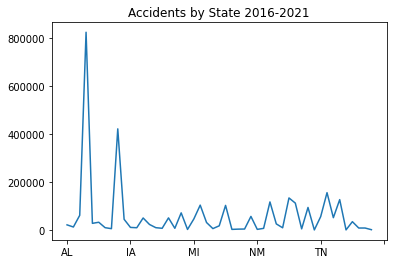

In [4]:
series = origin['State'].value_counts().sort_index()
series.plot(title='Accidents by State 2016-2021')

In [5]:
origin['State'].value_counts()

CA    823306
FL    421025
TX    155360
OR    133394
VA    126380
NY    116769
PA    111861
MN    103452
NC    102345
SC     93826
MD     71225
AZ     60927
NJ     56460
TN     55535
UT     51183
LA     50352
IL     49912
MI     46056
GA     44455
WA     34529
CT     32163
MO     31066
CO     27589
OH     25320
IN     22982
AL     21296
MT     17300
AR     12341
IA     10655
DC      9601
KS      9576
ID      9318
OK      9111
WI      8155
WV      8151
MA      6994
KY      6976
NV      6712
MS      5727
DE      5445
RI      4620
NH      3923
NE      3501
NM      2517
ND      2461
ME      2212
WY      1183
VT       368
SD       238
Name: State, dtype: int64

In [6]:
origin['Start_Time'] = pd.to_datetime(origin['Start_Time'])
origin = origin[(origin['State'] == 'CA') & (origin['Start_Time'].dt.year == 2021)]
df=origin.copy()
print(df.shape)
df.head()

(398436, 47)


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
237337,A-3404121,2,2021-07-30 23:37:00,2021-07-31 03:22:58,40.908676,-123.707116,40.904856,-123.740056,1.740,Accident on CA-96 (CA-299) from CR-7K100/Titlo...,35679.0,State Highway 299,L,Salyer,Humboldt,CA,95563,US,US/Pacific,KACV,2021-07-30 23:50:00,54.0,54.0,100.0,29.74,2.0,S,6.0,0.0,Fog,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
237340,A-3404124,2,2021-12-09 08:51:00,2021-12-09 11:01:22,37.419536,-122.090640,37.410966,-122.076087,0.994,Accident on Amphitheatre Pkwy (US-101) from Sh...,NaN,Bayshore Fwy S,R,Mountain View,Santa Clara,CA,94043,US,US/Pacific,KNUQ,2021-12-09 08:55:00,52.0,52.0,71.0,29.94,10.0,WNW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
237346,A-3404130,2,2021-12-17 09:59:30,2021-12-17 14:25:00,34.067525,-117.555253,34.083371,-117.633090,4.587,Slow traffic on I-10 W - San Bernardino Fwy W ...,NaN,I-10 W,R,Ontario,San Bernardino,CA,91761,US,US/Pacific,KONT,2021-12-17 09:53:00,55.0,55.0,59.0,29.10,10.0,W,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
237353,A-3404137,2,2021-06-05 11:31:00,2021-06-05 13:47:28,33.136771,-117.171024,33.137891,-117.176274,0.313,Accident on Twin Oaks Valley Rd (CA-78) from S...,NaN,CA-78 W,R,San Marcos,San Diego,CA,92069,US,US/Pacific,KCRQ,2021-06-05 11:53:00,67.0,67.0,66.0,29.62,10.0,WSW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
237374,A-3404158,2,2021-11-14 09:05:00,2021-11-14 11:29:19,33.713961,-117.964872,33.708591,-117.958442,0.524,Accident on Warner Ave (I-405) from Brookhurst...,NaN,I-405 S,R,Fountain Valley,Orange,CA,92708,US,US/Pacific,KSNA,2021-11-14 08:53:00,72.0,72.0,34.0,30.04,10.0,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day


Severity Counter({2: 397112, 4: 1324})


/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


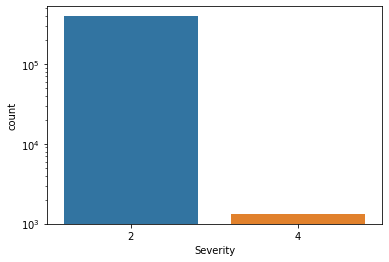

In [7]:
print("Severity",Counter(df['Severity']))
g = sns.countplot(df['Severity'], log=True)
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398436 entries, 237337 to 2217901
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     398436 non-null  object        
 1   Severity               398436 non-null  int64         
 2   Start_Time             398436 non-null  datetime64[ns]
 3   End_Time               398436 non-null  object        
 4   Start_Lat              398436 non-null  float64       
 5   Start_Lng              398436 non-null  float64       
 6   End_Lat                398436 non-null  float64       
 7   End_Lng                398436 non-null  float64       
 8   Distance(mi)           398436 non-null  float64       
 9   Description            398436 non-null  object        
 10  Number                 169994 non-null  float64       
 11  Street                 398435 non-null  object        
 12  Side                   398436 non-null

In [9]:
df.isna().sum()

ID                            0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                       0
End_Lng                       0
Distance(mi)                  0
Description                   0
Number                   228442
Street                        1
Side                          0
City                          2
County                        0
State                         0
Zipcode                     169
Country                       0
Timezone                    169
Airport_Code                705
Weather_Timestamp          7222
Temperature(F)            10404
Wind_Chill(F)             12947
Humidity(%)               10912
Pressure(in)               8357
Visibility(mi)             8503
Wind_Direction            11042
Wind_Speed(mph)           11041
Precipitation(in)         34639
Weather_Condition          9209
Amenity                       0
Bump    

/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


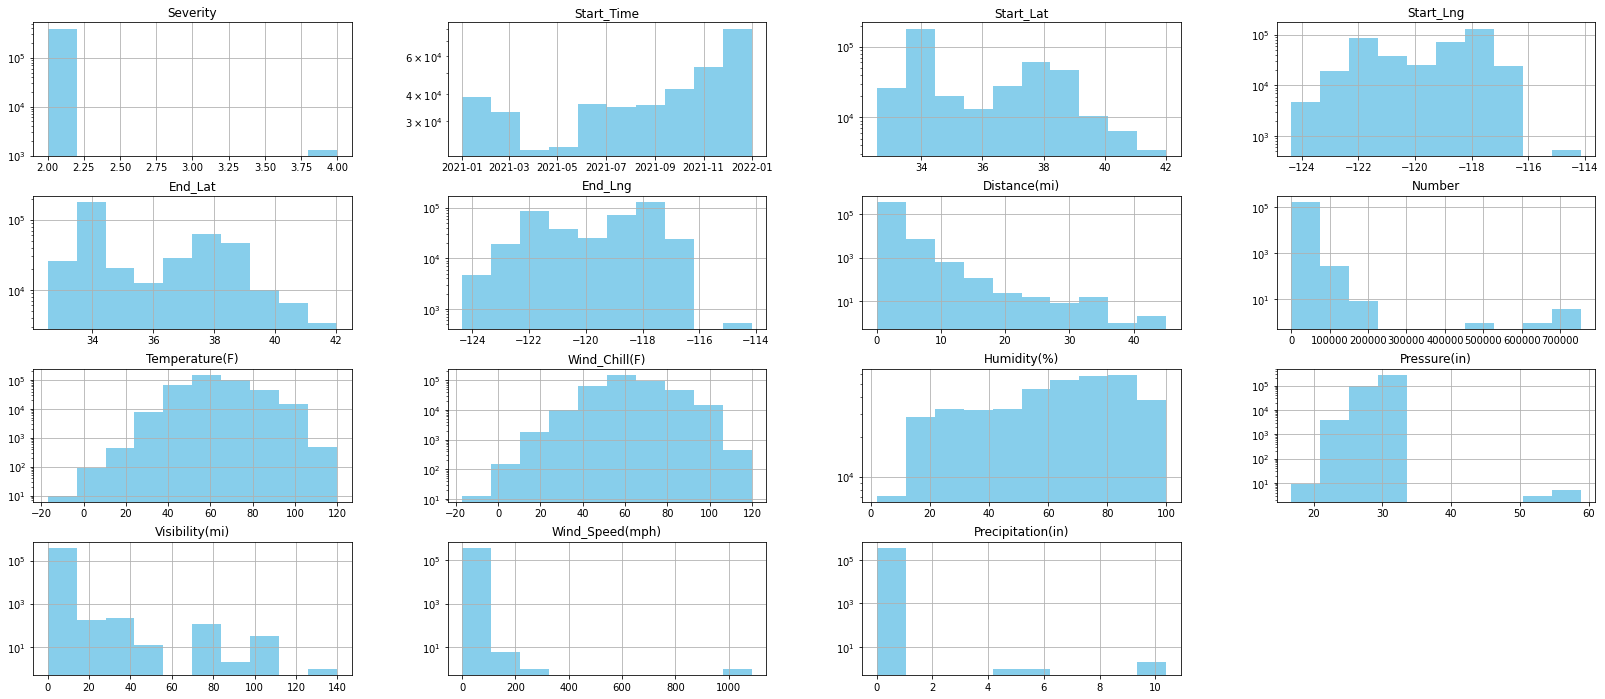

In [10]:
fig = plt.figure(figsize = (28,12))
ax = fig.gca()
df.hist(ax=ax, color = "skyblue", log=True)
plt.show()

In [11]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,398436.000000,398436.000000,398436.000000,398436.000000,398436.000000,398436.000000,169994.000000,388032.000000,385489.000000,387524.000000,390079.000000,389933.000000,387395.000000,363797.000000
mean,2.006646,35.683233,-119.437107,35.683517,-119.436365,0.758892,9103.412773,63.500619,63.135633,60.003716,29.445491,8.764105,6.127588,0.003843
std,0.115099,2.167827,1.897967,2.168178,1.898010,1.229754,11689.879637,14.371054,14.898460,24.882460,0.920842,3.059651,5.682774,0.036816
min,2.000000,32.543605,-124.374965,32.542032,-124.365736,0.000000,1.000000,-17.000000,-17.000000,2.000000,16.720000,0.000000,0.000000,0.000000
25%,2.000000,33.979072,-121.381126,33.978300,-121.382180,0.092000,1724.000000,54.000000,54.000000,40.000000,29.290000,9.000000,0.000000,0.000000
50%,2.000000,34.293619,-118.461133,34.296219,-118.463169,0.313000,5093.000000,62.000000,62.000000,63.000000,29.760000,10.000000,6.000000,0.000000
75%,2.000000,37.720602,-117.890505,37.721714,-117.891088,0.927000,12921.000000,72.000000,72.000000,81.000000,29.920000,10.000000,9.000000,0.000000
max,4.000000,42.005364,-114.138935,42.037082,-114.139815,45.123000,753601.000000,120.000000,120.000000,100.000000,58.900000,140.000000,1087.000000,10.400000


In [12]:
df['Hr'] = df['Start_Time'].dt.hour
df['Weekday']= df['Start_Time'].dt.weekday
df['Day'] = df['Start_Time'].dt.day
df['Date'] = df['Start_Time'].dt.date
df['Month'] = df['Start_Time'].dt.month

In [13]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hr,Weekday,Day,Date,Month
237337,A-3404121,2,2021-07-30 23:37:00,2021-07-31 03:22:58,40.908676,-123.707116,40.904856,-123.740056,1.740,Accident on CA-96 (CA-299) from CR-7K100/Titlo...,35679.0,State Highway 299,L,Salyer,Humboldt,CA,95563,US,US/Pacific,KACV,2021-07-30 23:50:00,54.0,54.0,100.0,29.74,2.0,S,6.0,0.0,Fog,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,23,4,30,2021-07-30,7
237340,A-3404124,2,2021-12-09 08:51:00,2021-12-09 11:01:22,37.419536,-122.090640,37.410966,-122.076087,0.994,Accident on Amphitheatre Pkwy (US-101) from Sh...,NaN,Bayshore Fwy S,R,Mountain View,Santa Clara,CA,94043,US,US/Pacific,KNUQ,2021-12-09 08:55:00,52.0,52.0,71.0,29.94,10.0,WNW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,8,3,9,2021-12-09,12
237346,A-3404130,2,2021-12-17 09:59:30,2021-12-17 14:25:00,34.067525,-117.555253,34.083371,-117.633090,4.587,Slow traffic on I-10 W - San Bernardino Fwy W ...,NaN,I-10 W,R,Ontario,San Bernardino,CA,91761,US,US/Pacific,KONT,2021-12-17 09:53:00,55.0,55.0,59.0,29.10,10.0,W,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9,4,17,2021-12-17,12
237353,A-3404137,2,2021-06-05 11:31:00,2021-06-05 13:47:28,33.136771,-117.171024,33.137891,-117.176274,0.313,Accident on Twin Oaks Valley Rd (CA-78) from S...,NaN,CA-78 W,R,San Marcos,San Diego,CA,92069,US,US/Pacific,KCRQ,2021-06-05 11:53:00,67.0,67.0,66.0,29.62,10.0,WSW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,11,5,5,2021-06-05,6
237374,A-3404158,2,2021-11-14 09:05:00,2021-11-14 11:29:19,33.713961,-117.964872,33.708591,-117.958442,0.524,Accident on Warner Ave (I-405) from Brookhurst...,NaN,I-405 S,R,Fountain Valley,Orange,CA,92708,US,US/Pacific,KSNA,2021-11-14 08:53:00,72.0,72.0,34.0,30.04,10.0,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9,6,14,2021-11-14,11


<AxesSubplot:title={'center':'Accidents by Date'}>

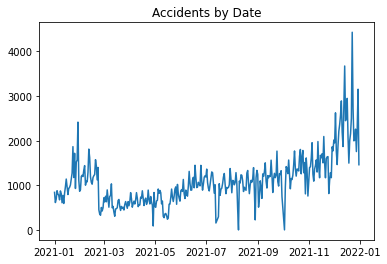

In [14]:
series = df['Date'].value_counts().sort_index()
series.plot(title='Accidents by Date')

In [15]:
df['Date'].value_counts()

2021-12-23    4430
2021-12-14    3674
2021-12-30    3154
2021-12-17    2949
2021-12-10    2892
              ... 
2021-08-29     228
2021-07-13     158
2021-04-29      91
2021-10-03       4
2021-08-09       3
Name: Date, Length: 360, dtype: int64

<AxesSubplot:title={'center':'Accidents by Weekday'}>

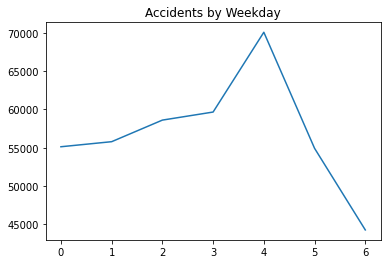

In [16]:
series = df['Weekday'].value_counts().sort_index()
series.plot(title='Accidents by Weekday')

<AxesSubplot:title={'center':'Accidents by Hour'}>

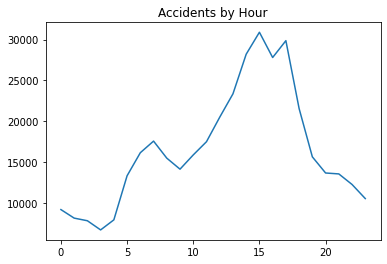

In [17]:
series = df['Hr'].value_counts().sort_index()
series.plot(title='Accidents by Hour')

#### Map

In [18]:
df_new = df.dropna(subset=['Start_Lng', 'Start_Lat'])
crs = {'init': 'epsg:3310'}
geometry = [Point(xy) for xy in zip(df_new.Start_Lng, df_new.Start_Lat)]
geometry[:3]

In [19]:
geo_df = gpd.GeoDataFrame(df_new, crs=crs, geometry=geometry)

/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
geo_df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hr,Weekday,Day,Date,Month,geometry
237337,A-3404121,2,2021-07-30 23:37:00,2021-07-31 03:22:58,40.908676,-123.707116,40.904856,-123.740056,1.740,Accident on CA-96 (CA-299) from CR-7K100/Titlo...,35679.0,State Highway 299,L,Salyer,Humboldt,CA,95563,US,US/Pacific,KACV,2021-07-30 23:50:00,54.0,54.0,100.0,29.74,2.0,S,6.0,0.0,Fog,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,23,4,30,2021-07-30,7,POINT (-123.707 40.909)
237340,A-3404124,2,2021-12-09 08:51:00,2021-12-09 11:01:22,37.419536,-122.090640,37.410966,-122.076087,0.994,Accident on Amphitheatre Pkwy (US-101) from Sh...,NaN,Bayshore Fwy S,R,Mountain View,Santa Clara,CA,94043,US,US/Pacific,KNUQ,2021-12-09 08:55:00,52.0,52.0,71.0,29.94,10.0,WNW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,8,3,9,2021-12-09,12,POINT (-122.091 37.420)
237346,A-3404130,2,2021-12-17 09:59:30,2021-12-17 14:25:00,34.067525,-117.555253,34.083371,-117.633090,4.587,Slow traffic on I-10 W - San Bernardino Fwy W ...,NaN,I-10 W,R,Ontario,San Bernardino,CA,91761,US,US/Pacific,KONT,2021-12-17 09:53:00,55.0,55.0,59.0,29.10,10.0,W,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9,4,17,2021-12-17,12,POINT (-117.555 34.068)
237353,A-3404137,2,2021-06-05 11:31:00,2021-06-05 13:47:28,33.136771,-117.171024,33.137891,-117.176274,0.313,Accident on Twin Oaks Valley Rd (CA-78) from S...,NaN,CA-78 W,R,San Marcos,San Diego,CA,92069,US,US/Pacific,KCRQ,2021-06-05 11:53:00,67.0,67.0,66.0,29.62,10.0,WSW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,11,5,5,2021-06-05,6,POINT (-117.171 33.137)
237374,A-3404158,2,2021-11-14 09:05:00,2021-11-14 11:29:19,33.713961,-117.964872,33.708591,-117.958442,0.524,Accident on Warner Ave (I-405) from Brookhurst...,NaN,I-405 S,R,Fountain Valley,Orange,CA,92708,US,US/Pacific,KSNA,2021-11-14 08:53:00,72.0,72.0,34.0,30.04,10.0,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9,6,14,2021-11-14,11,POINT (-117.965 33.714)


In [22]:
usa = gpd.read_file("States 21basic/geo_export_efb7f0f6-2553-4f92-8d29-cffec36c5512.shp")
usa.head()

,drawseq,state_abbr,state_fips,state_name,sub_region,geometry
0,NaN,HI,15,Hawaii,Pacific,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,NaN,WA,53,Washington,Pacific,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,NaN,MT,30,Montana,Mountain,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,NaN,ME,23,Maine,New England,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,NaN,ND,38,North Dakota,West North Central,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


<AxesSubplot:>

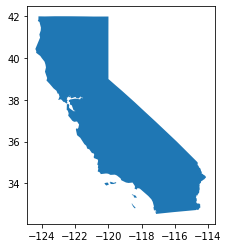

In [23]:
usa[usa.state_abbr == "CA"].plot()

In [24]:
ca_map=usa[usa.state_abbr == "CA"]

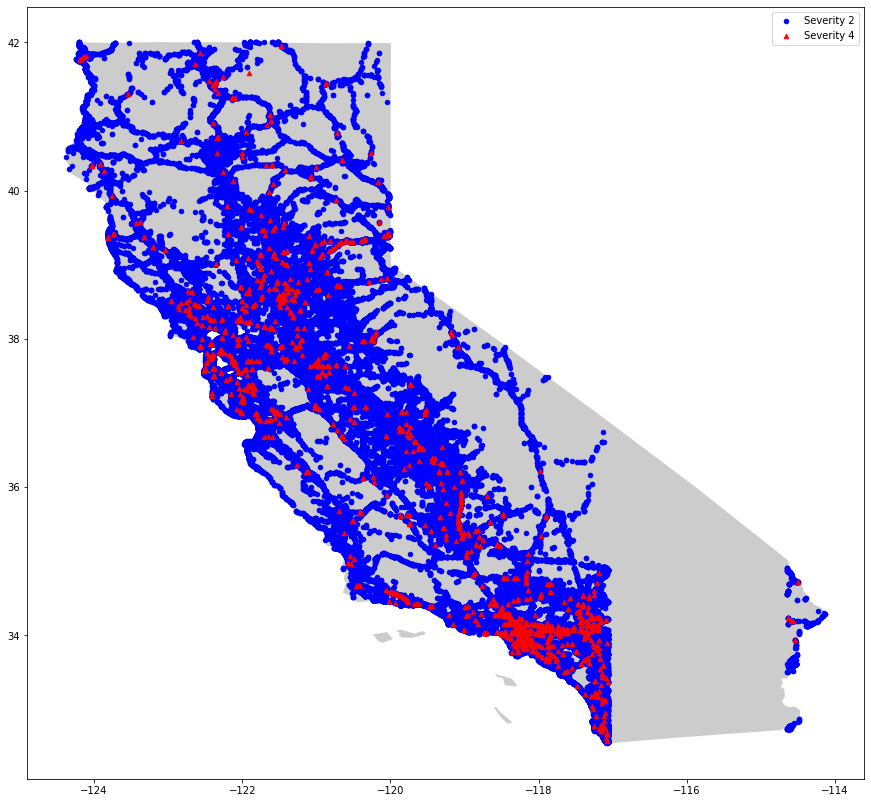

In [25]:
fig,ax = plt.subplots(figsize = (15,15))
ca_map.plot(color='grey', ax=ax, alpha = 0.4)
geo_df[geo_df['Severity']==2].geometry.plot(ax=ax, markersize=20, color='blue', marker='o', label='Severity 2')
geo_df[geo_df['Severity']==4].geometry.plot(ax=ax, markersize=20, color='red', marker='^', label='Severity 4')
plt.legend()

In [26]:
#count the number of values present in each row and save an image of the rows with the least values
df['row_value_count'] = df.apply(lambda x: x.count(), axis=1)
df_head = df.sort_values("row_value_count", ascending=True).head()
dfi.export(df_head, "row_value_count_before.png", max_cols=-1)

[0318/101126.006510:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmppm3ys1ao/temp.png.
[0318/101127.132173:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpc0epenck/temp.png.
[0318/101128.546472:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpltaey951/temp.png.
[0318/101130.455028:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmp5ol14ik4/temp.png.
[0318/101133.134829:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpmkmxz3go/temp.png.


In [27]:
df.drop(['row_value_count'], axis=1, inplace=True)

### Cleaning Data

In [28]:
# Step1: Deduplicate your data
# We dont have duplicate data
print(df.shape)
print(df.drop_duplicates().shape)

(398436, 52)
(398436, 52)


In [29]:
# Step2: Remove irrelevant data
df = df.drop(['ID', 'Description', 'Number', 'End_Time', 'End_Lat', 'End_Lng', 'Country', 'Turning_Loop', 'Weather_Timestamp'], axis=1)
df.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hr,Weekday,Day,Date,Month
237337,2,2021-07-30 23:37:00,40.908676,-123.707116,1.740,State Highway 299,L,Salyer,Humboldt,CA,95563,US/Pacific,KACV,54.0,54.0,100.0,29.74,2.0,S,6.0,0.0,Fog,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,23,4,30,2021-07-30,7
237340,2,2021-12-09 08:51:00,37.419536,-122.090640,0.994,Bayshore Fwy S,R,Mountain View,Santa Clara,CA,94043,US/Pacific,KNUQ,52.0,52.0,71.0,29.94,10.0,WNW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,8,3,9,2021-12-09,12
237346,2,2021-12-17 09:59:30,34.067525,-117.555253,4.587,I-10 W,R,Ontario,San Bernardino,CA,91761,US/Pacific,KONT,55.0,55.0,59.0,29.10,10.0,W,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9,4,17,2021-12-17,12
237353,2,2021-06-05 11:31:00,33.136771,-117.171024,0.313,CA-78 W,R,San Marcos,San Diego,CA,92069,US/Pacific,KCRQ,67.0,67.0,66.0,29.62,10.0,WSW,9.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,11,5,5,2021-06-05,6
237374,2,2021-11-14 09:05:00,33.713961,-117.964872,0.524,I-405 S,R,Fountain Valley,Orange,CA,92708,US/Pacific,KSNA,72.0,72.0,34.0,30.04,10.0,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,Day,Day,Day,Day,9,6,14,2021-11-14,11


In [30]:
# Step3: Filling missing data
def fillMissing(column, group_col):
    print("Original missing data - {}: {}".format(column, df.isnull().sum()[column]))
    df[column] = df.groupby(["Month", group_col])[column].transform(lambda x: x.fillna(x.median()))
    print("After: {}".format(df.isnull().sum()[column]))

In [31]:
handle_missing_col = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
print(df[df.isnull().any(axis=1)].shape)
for col in handle_missing_col:
    fillMissing(col, 'Airport_Code')
    fillMissing(col, 'City')
    fillMissing(col, 'County')
print(df[df.isnull().any(axis=1)].shape)

(42740, 43)
Original missing data - Temperature(F): 10404
After: 5867
Original missing data - Temperature(F): 5867
After: 5555
Original missing data - Temperature(F): 5555
After: 44
Original missing data - Wind_Chill(F): 12947
After: 5867
Original missing data - Wind_Chill(F): 5867
After: 5555
Original missing data - Wind_Chill(F): 5555
After: 44
Original missing data - Humidity(%): 10912
After: 5867
Original missing data - Humidity(%): 5867
After: 5555
Original missing data - Humidity(%): 5555
After: 44
Original missing data - Pressure(in): 8357
After: 4965
Original missing data - Pressure(in): 4965
After: 4653
Original missing data - Pressure(in): 4653
After: 44
Original missing data - Visibility(mi): 8503
After: 4967
Original missing data - Visibility(mi): 4967
After: 4655
Original missing data - Visibility(mi): 4655
After: 44
Original missing data - Wind_Speed(mph): 11041
After: 4965
Original missing data - Wind_Speed(mph): 4965
After: 4653
Original missing data - Wind_Speed(mph): 

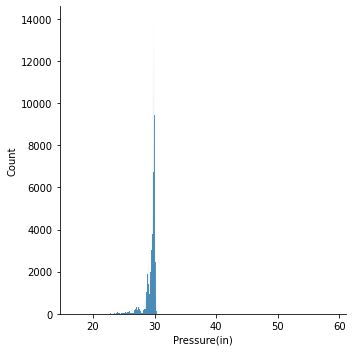

In [32]:
ax = sns.displot(x=df["Pressure(in)"])

In [33]:
#Filling Category data
#Create bins
bins = [0, 5, 10, 15, 20, 25, 26, 27, 28, 28.5, 29, 29.5, 30, 35, 40, 45, 50, 55, 60]
df['Pressure_binned'] = pd.cut(df['Pressure(in)'], bins)

In [34]:
# Use mode for cat variables
df["Wind_Direction"] = df.groupby(["Month", "Pressure_binned"])["Wind_Direction"].apply(lambda x: x.fillna(x.value_counts().index[0]))
df["Wind_Direction"].isna().sum()

44

In [35]:
# Use mode for cat variables
df["Weather_Condition"] = df.groupby(["Month", "Pressure_binned"])["Weather_Condition"].apply(lambda x: x.fillna(x.value_counts().index[0]))
df["Weather_Condition"].isna().sum()

44

In [36]:
df.drop(['Pressure_binned'], axis=1, inplace=True)

In [37]:
# Step4: Drop the rows that still have missing data
print(df.shape)
df = df.dropna()
print(df.shape)
df.isnull().sum()

(398436, 43)
(397658, 43)


Severity                 0
Start_Time               0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Timezone                 0
Airport_Code             0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
A

/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


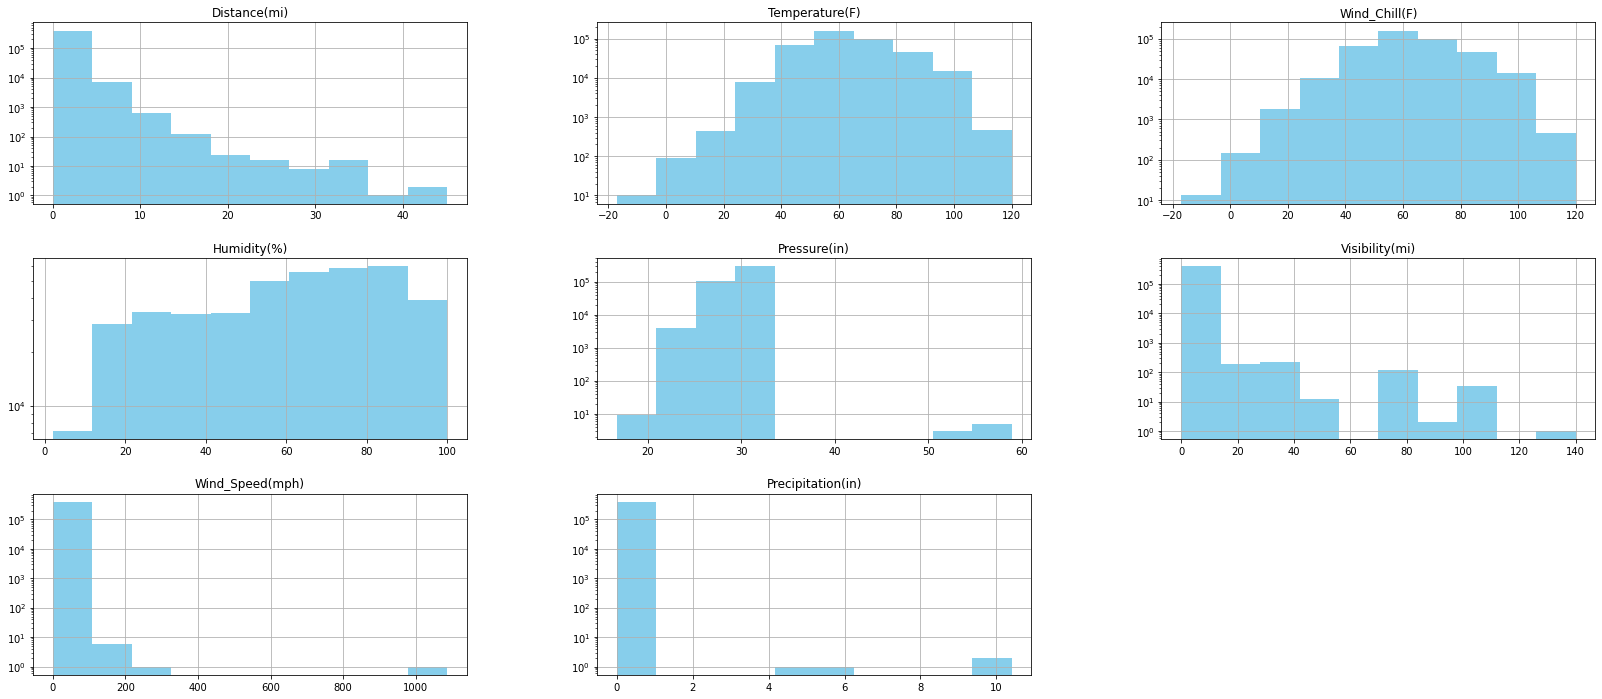

In [38]:
# Step5: Remove obvious outliers
# Select numeric columns
df_numeric = df.select_dtypes(include='number')
# Drop cols
df_numeric = df_numeric.drop(['Start_Lat', 'Start_Lng', 'Hr', 'Weekday', 'Day', 'Month', 'Severity'], axis=1)
# view histograms
fig = plt.figure(figsize = (28,12))
ax = fig.gca()
df_numeric.hist(ax=ax, color = "skyblue", log=True)
plt.show()

In [39]:
#drop rows where pressure > 40 and wind speed > 400 since these values are impossible
df.drop(df[(df['Pressure(in)'] > 40) | (df['Wind_Speed(mph)'] > 400)].index, inplace=True)

/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


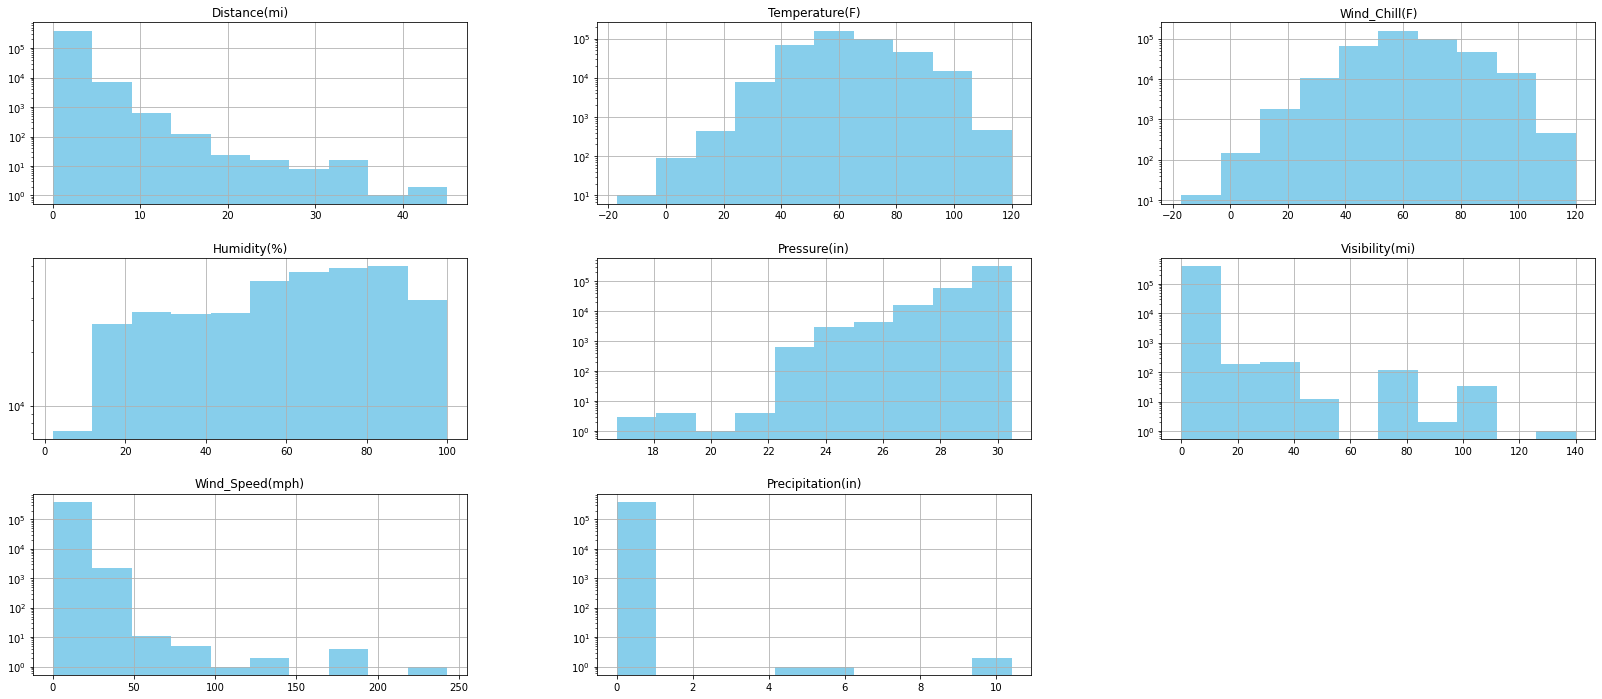

In [40]:
# Select numeric columns
df_numeric = df.select_dtypes(include='number')
# Drop cols
df_numeric = df_numeric.drop(['Start_Lat', 'Start_Lng', 'Hr', 'Weekday', 'Day', 'Month', 'Severity'], axis=1)
# view histograms
fig = plt.figure(figsize = (28,12))
ax = fig.gca()
df_numeric.hist(ax=ax, color = "skyblue", log=True)
plt.show()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397649 entries, 237337 to 2217901
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Severity               397649 non-null  int64         
 1   Start_Time             397649 non-null  datetime64[ns]
 2   Start_Lat              397649 non-null  float64       
 3   Start_Lng              397649 non-null  float64       
 4   Distance(mi)           397649 non-null  float64       
 5   Street                 397649 non-null  object        
 6   Side                   397649 non-null  object        
 7   City                   397649 non-null  object        
 8   County                 397649 non-null  object        
 9   State                  397649 non-null  object        
 10  Zipcode                397649 non-null  object        
 11  Timezone               397649 non-null  object        
 12  Airport_Code           397649 non-null

Severity Counter({2: 396330, 4: 1319})


/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


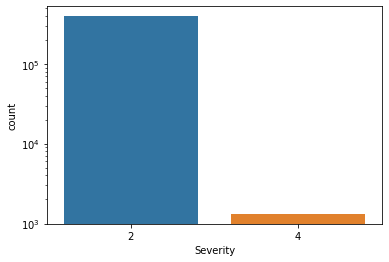

In [42]:
print("Severity",Counter(df['Severity']))
g = sns.countplot(df['Severity'], log=True)
plt.show()

In [43]:
#count the number of values present in each row and save an image of the rows with the least values
df['row_value_count'] = df.apply(lambda x: x.count(), axis=1)
df_head = df.sort_values("row_value_count", ascending=True).head()
dfi.export(df_head, "row_value_count_after.png", max_cols=-1)

[0318/101325.283463:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmp66zdz2vj/temp.png.
[0318/101326.378918:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpyaqz9_36/temp.png.
[0318/101327.840500:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpeom79qst/temp.png.
[0318/101329.792235:INFO:headless_shell.cc(659)] Written to file /var/folders/k0/pttv5w_52mn594lng62t05hh0000gn/T/tmpminijac9/temp.png.


In [44]:
df.drop(['row_value_count'], axis=1, inplace=True)

### Feature Engineering

In [45]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Timezone',
       'Airport_Code', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hr',
       'Weekday', 'Day', 'Date', 'Month'],
      dtype='object')

##### Hour Category

In [46]:
df['Hr_Category'] = np.nan
df.loc[(df.Weekday < 5)&(df.Hr <= 9)&(df.Hr >= 7), 'Hr_Category'] = "rush"
df.loc[(df.Weekday < 5)&(df.Hr <= 19)&(df.Hr >= 16), 'Hr_Category'] = "rush"
df.loc[(df.Weekday < 5)&(df.Hr < 16)&(df.Hr > 9), 'Hr_Category'] = "day"  # between working hour
df.loc[(df.Weekday < 5)&(df.Hr < 7)|(df.Hr > 19), 'Hr_Category'] = "night" # After or Before working hour
df.loc[(df.Weekday >= 5)&(df.Hr <= 20)&(df.Hr >= 8), 'Hr_Category'] = "weekend_day"  # between working hour
df.loc[(df.Weekday >= 5)&(df.Hr < 8)|(df.Hr > 20), 'Hr_Category'] = "weekend_night" # After or Before working hour

##### Wind Direction

In [47]:
print("Wind Direction: ", df['Wind_Direction'].unique())
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction:  ['S' 'WNW' 'W' 'WSW' 'CALM' 'VAR' 'E' 'SSE' 'ESE' 'NNW' 'N' 'SE' 'SW' 'NW'
 'SSW' 'NE' 'ENE' 'NNE']
Wind Direction after simplification:  ['S' 'W' 'CALM' 'VAR' 'E' 'N' 'SE' 'SW' 'NW' 'NE']


##### Wind Condition

In [48]:
weather ='!'.join(df['Weather_Condition'].unique().tolist())
weather = np.unique(np.array(re.split("!|\/",weather))).tolist()
print(weather)

[' Windy', 'A Precipitation', 'Blowing Dust', 'Blowing Dust ', 'Blowing Sand', 'Cloudy', 'Cloudy ', 'Drizzle', 'Duststorm', 'Fair', 'Fair ', 'Fog', 'Fog ', 'Haze', 'Haze ', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Rain ', 'Heavy Snow', 'Heavy Snow ', 'Heavy T-Storm', 'Light Drizzle', 'Light Drizzle ', 'Light Rain', 'Light Rain ', 'Light Rain Shower', 'Light Rain with Thunder', 'Light Snow', 'Light Snow ', 'Mist', 'Mostly Cloudy', 'Mostly Cloudy ', 'N', 'Partial Fog', 'Partly Cloudy', 'Partly Cloudy ', 'Patches of Fog', 'Rain', 'Rain ', 'Rain Shower', 'Sand ', 'Shallow Fog', 'Showers in the Vicinity', 'Smoke', 'Smoke ', 'Snow', 'Snow ', 'Squalls ', 'T-Storm', 'T-Storm ', 'Thunder', 'Thunder ', 'Thunder and Hail', 'Thunder in the Vicinity', 'Widespread Dust ', 'Wintry Mix', 'Wintry Mix ']


In [49]:
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), True, False)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), True, False)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), True, False)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms|Squalls', case=False, na = False), True, False)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), True, False)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers', case=False, na = False), True, False)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), True, False)

##### Street

In [50]:
# create a list of top 40 most common words in street name
st_type =' '.join(df['Street'].unique().tolist()) # flat the array of street name
st_type = re.split(" |-", st_type) # split the long string by space and hyphen
st_type = [x[0] for x in Counter(st_type).most_common(40)] # select the 40 most common words
print('the 40 most common words')
print(*st_type, sep = ", ") 

the 40 most common words
, Rd, Ave, St, Dr, Ln, E, Way, W, S, N, Blvd, Ct, Highway, Pl, Road, Canyon, Avenue, Valley, Creek, State, Pkwy, Cir, San, Hwy, Ranch, CA, Park, Hill, La, Vista, Via, County, Old, El, Lake, Oak, Trl, Mountain, Ridge


In [51]:
st_type= [' Rd', ' St', ' Dr', ' Ave', ' Blvd', ' Ln', ' Highway', ' Pkwy', ' Hwy', 
          ' Way', ' Ct', 'Pl', ' Road', 'US-', 'Creek', ' Cir',  'Route', 'Trl', 'Pike', ' Fwy']
print(*st_type, sep = ", ") 

# for each word create a boolean column
for i in st_type:
    df[i.strip()] = np.where(df['Street'].str.contains(i, case=True, na = False), True, False)
df.loc[df['Road']==1,'Rd'] = True
df.loc[df['Highway']==1,'Hwy'] = True


 Rd,  St,  Dr,  Ave,  Blvd,  Ln,  Highway,  Pkwy,  Hwy,  Way,  Ct, Pl,  Road, US-, Creek,  Cir, Route, Trl, Pike,  Fwy


### Prepare Training and Testing Data

In [52]:
drop_col = ['Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'State', 'Zipcode',
       'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Date']
df = df.drop(drop_col, axis=1)

In [53]:
df = df.replace([True, False], [1,0])

cat = ['Side','Timezone','County','Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hr_Category']
df[cat] = df[cat].astype('category')
df = pd.get_dummies(df, columns=cat)

In [54]:
print(df.shape)
df.head()

(397649, 126)


,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Hr,Weekday,Day,Month,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Rd,St,Dr,Ave,Blvd,Ln,Highway,Pkwy,Hwy,Way,Ct,Pl,Road,US-,Creek,Cir,Route,Trl,Pike,Fwy,Side_L,Side_R,Timezone_US/Mountain,Timezone_US/Pacific,County_Alameda,County_Alpine,County_Amador,County_Butte,County_Calaveras,County_Colusa,County_Contra Costa,County_Del Norte,County_El Dorado,County_Fresno,County_Glenn,County_Humboldt,County_Imperial,County_Inyo,County_Kern,County_Kings,County_Lake,County_Lassen,County_Los Angeles,County_Madera,County_Marin,County_Mariposa,County_Mendocino,County_Merced,County_Modoc,County_Mono,County_Monterey,County_Napa,County_Nevada,County_Orange,County_Placer,County_Plumas,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Francisco,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Sierra,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tehama,County_Trinity,County_Tulare,County_Tuolumne,County_Ventura,County_Yolo,County_Yuba,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Civil_Twilight_Day,Civil_Twilight_Night,Nautical_Twilight_Day,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Hr_Category_day,Hr_Category_night,Hr_Category_rush,Hr_Category_weekend_day,Hr_Category_weekend_night
237337,2,54.0,54.0,100.0,29.74,2.0,6.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,23,4,30,7,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
237340,2,52.0,52.0,71.0,29.94,10.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,9,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
237346,2,55.0,55.0,59.0,29.10,10.0,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,17,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
237353,2,67.0,67.0,66.0,29.62,10.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,11,5,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
237374,2,72.0,72.0,34.0,30.04,10.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,9,6,14,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0


In [55]:
print(Counter(df['Severity']))
df['Severity'] = df['Severity'].replace(2,1).replace(4,0)
print(Counter(df['Severity']))

Counter({2: 396330, 4: 1319})
Counter({1: 396330, 0: 1319})


In [56]:
X = df.drop(['Severity'], axis=1)
y = df['Severity']

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_ = X 
num_col = X.columns[:7]
num_df = X.iloc[:,:7]
standard = scaler.fit_transform(num_df)
for i in range(num_df.shape[1]):
    X_[num_col[i]] = standard[:,i]
X_

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Hr,Weekday,Day,Month,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Rd,St,Dr,Ave,Blvd,Ln,Highway,Pkwy,Hwy,Way,Ct,Pl,Road,US-,Creek,Cir,Route,Trl,Pike,Fwy,Side_L,Side_R,Timezone_US/Mountain,Timezone_US/Pacific,County_Alameda,County_Alpine,County_Amador,County_Butte,County_Calaveras,County_Colusa,County_Contra Costa,County_Del Norte,County_El Dorado,County_Fresno,County_Glenn,County_Humboldt,County_Imperial,County_Inyo,County_Kern,County_Kings,County_Lake,County_Lassen,County_Los Angeles,County_Madera,County_Marin,County_Mariposa,County_Mendocino,County_Merced,County_Modoc,County_Mono,County_Monterey,County_Napa,County_Nevada,County_Orange,County_Placer,County_Plumas,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Francisco,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Sierra,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tehama,County_Trinity,County_Tulare,County_Tuolumne,County_Ventura,County_Yolo,County_Yuba,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Civil_Twilight_Day,Civil_Twilight_Night,Nautical_Twilight_Day,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Hr_Category_day,Hr_Category_night,Hr_Category_rush,Hr_Category_weekend_day,Hr_Category_weekend_night
237337,-0.660262,-0.614512,1.615318,0.325371,-2.233076,-0.021016,-0.100114,0,0,0,0,0,0,0,0,0,0,0,0,23,4,30,7,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
237340,-0.799895,-0.749316,0.443367,0.543733,0.401033,0.537685,-0.100114,0,0,0,0,0,0,0,0,0,0,0,0,8,3,9,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
237346,-0.590445,-0.547110,-0.041578,-0.373389,0.401033,0.165218,-0.100114,0,0,0,0,0,0,0,0,0,0,0,0,9,4,17,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
237353,0.247352,0.261713,0.241307,0.194353,0.401033,0.537685,-0.100114,0,0,0,0,0,0,0,0,0,0,0,0,11,5,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
237374,0.596435,0.598723,-1.051881,0.652915,0.401033,-1.138420,-0.100114,0,0,0,0,1,0,0,0,0,0,0,0,9,6,14,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215886,-1.218794,-1.355933,0.120070,0.565570,0.401033,-0.021016,-0.100114,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0
2216166,-0.520629,-0.479708

In [102]:
# from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier()
# model.fit(X,y)
# feat_labels = df.columns[1:]
# feature_dict = dict(zip(feat_labels, model.feature_importances_))
# # sorted(feature_dict.items(), key=lambda x:x[1], reverse=True)
# select_features = []
# for k,v in feature_dict.items():
#     if v > 0.01:
#         select_features.append(k)
# select_features

In [103]:
# df_new = df[select_features]
# dummy_cat = ['Month', 'Day', 'Hr', 'Weekday']
# df_new[dummy_cat] = df_new[dummy_cat].astype('category')
# df_new = pd.get_dummies(df_new, columns=dummy_cat, drop_first=True)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state=42)

(3690, 126)
Severity Counter({1: 2774, 0: 916})


/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


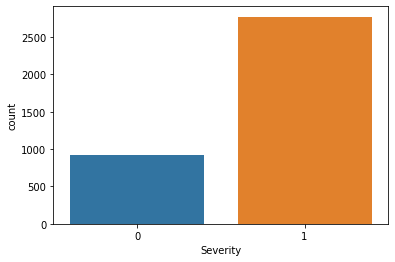

In [59]:
df_new = pd.concat([X_train,y_train],axis=1)
Severity_4 = df_new[df_new['Severity']==0]
Severity_2 = df_new[df_new['Severity']==1]
Severity_2 = Severity_2.sample(frac=0.01, replace=False, random_state=42)
data = pd.concat([Severity_2, Severity_4])
print(data.shape)
print("Severity",Counter(data['Severity']))
g = sns.countplot(data['Severity'])
plt.show()
X_ = data.drop(['Severity'], axis=1)
y_ = data['Severity']

In [60]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over = RandomOverSampler(random_state=42)
X_over, y_over = over.fit_resample(X_, y_)

Counter({1: 396330, 0: 1319})
Severity Counter({1: 2774, 0: 2774})


/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


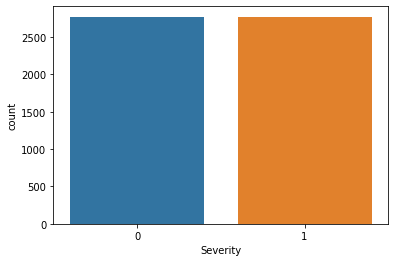

In [61]:
print(Counter(y))
print("Severity",Counter(y_over))
g = sns.countplot(y_over)
plt.show()

In [ ]:
# under = RandomUnderSampler(sampling_strategy=0.5)
# X_under, y_under = under.fit_resample(X_train, y_train)

In [ ]:
# X_ = pd.concat([X_over, X_under])
# y_ = pd.concat([y_over, y_under])

### Training Model

In [62]:
from sklearn.neighbors import KNeighborsClassifier
def KNN_autotune(X,y):
    # defining parameter range 
    param_test = {'n_neighbors': [3,5,10]
                } 

    gsearch = GridSearchCV(KNeighborsClassifier(metric='minkowski', p=2), param_grid = param_test, refit = True, verbose = 3, cv=5)
    
    register_spark() # register spark backendΩ
    with parallel_backend('spark',n_jobs=8):
        gsearch.fit(X,y)
    print('____________________________________________')
    print('tune KNN')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(gsearch.predict(X),y)

    return gsearch.best_estimator_

In [63]:
KNN_param = KNN_autotune(X_over,y_over)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/18 10:14:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend SparkDistributedBackend with 8 concurrent workers.
[CV] n_neighbors=3 ................................................... 1) / 1]1]
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=3, score=0.813, total=   0.4s
[CV] ....................... n_neighbors=3, score=0.795, total=   0.3s
[CV] ....................... n_neighbors=5, score=0.725, total=   0.4s
[CV] ....................... n_neighbors=3, score=0.778, total=   0.4s
[CV] ....................... n_neighbors=5, score=0

____________________________________________
tune KNN
____________________________________________
{'mean_fit_time': array([0.08960991, 0.06129308, 0.04767699]), 'std_fit_time': array([0.01166499, 0.01911012, 0.00826449]), 'mean_score_time': array([0.31232052, 0.34307551, 0.35236468]), 'std_score_time': array([0.05056914, 0.03698161, 0.0397483 ]), 'param_n_neighbors': masked_array(data=[3, 5, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 3}, {'n_neighbors': 5}, {'n_neighbors': 10}], 'split0_test_score': array([0.77837838, 0.72522523, 0.67297297]), 'split1_test_score': array([0.8       , 0.75945946, 0.71351351]), 'split2_test_score': array([0.81261261, 0.75315315, 0.69279279]), 'split3_test_score': array([0.77908025, 0.74030658, 0.69251578]), 'split4_test_score': array([0.79531109, 0.73038774, 0.70333634]), 'mean_test_score': array([0.79307647, 0.74170643, 0.69502628]), 'std_test_score': array([0.01301167, 0.01

In [64]:
y_pred = KNN_param.predict(X_test)

[[  237   166]
 [35870 83022]]
Precision: 99.8%
Recall: 69.83%
F1 score: 82.17%


<AxesSubplot:>

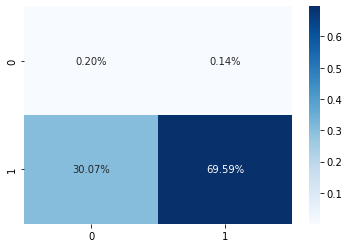

In [65]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

#Measurements
print('Precision: {}%'.format(round(precision_score(y_test, y_pred, average='binary')*100,2)))
print('Recall: {}%'.format(round(recall_score(y_test, y_pred, average='binary')*100,2)))
print('F1 score: {}%'.format(round(f1_score(y_test, y_pred, average='binary')*100,2)))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ROC_AUC score: 64.32%


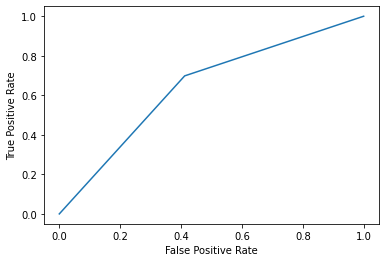

In [66]:
print('ROC_AUC score: '+str(round(roc_auc_score(y_test,y_pred)*100,2))+'%')
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.59      0.01       403
           1       1.00      0.70      0.82    118892

    accuracy                           0.70    119295
   macro avg       0.50      0.64      0.42    119295
weighted avg       0.99      0.70      0.82    119295



In [68]:
def RFC_autotune(X,y):
    # defining parameter range 
    param_test = {'n_estimators': [10,100,300,500,1000]
                } 

    gsearch = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid = param_test, refit = True, verbose = 3, cv=5)
    
    register_spark() # register spark backendΩ
    with parallel_backend('spark',n_jobs=8):
        gsearch.fit(X,y)
    print('____________________________________________')
    print('tune RFC')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(gsearch.predict(X),y)

    return gsearch.best_estimator_

In [69]:
RFC_param = RFC_autotune(X_over,y_over)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend SparkDistributedBackend with 8 concurrent workers.
[CV] n_estimators=10 .................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.866, total=   0.1s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.891, total=   0.1s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.891, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ..................... n_estimators=10, score=0.887, total=   0.1s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.878, total=   0.1s
[CV] n_estimators=100 .......................................

____________________________________________
tune RFC
____________________________________________
{'mean_fit_time': array([0.06475658, 0.58358459, 2.16201644, 3.77633519, 6.0331811 ]), 'std_fit_time': array([0.00208085, 0.08077162, 0.08493661, 0.06250034, 0.49436703]), 'mean_score_time': array([0.00545087, 0.02541075, 0.12110105, 0.17503839, 0.22119756]), 'std_score_time': array([0.00023681, 0.00138937, 0.02334897, 0.02409528, 0.01397002]), 'param_n_estimators': masked_array(data=[10, 100, 300, 500, 1000],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 10}, {'n_estimators': 100}, {'n_estimators': 300}, {'n_estimators': 500}, {'n_estimators': 1000}], 'split0_test_score': array([0.86576577, 0.92072072, 0.91621622, 0.91081081, 0.91531532]), 'split1_test_score': array([0.88738739, 0.92792793, 0.92882883, 0.92702703, 0.92702703]), 'split2_test_score': array([0.87837838, 0.94054054, 0.94414414, 0.94414414,

In [70]:
y_pred = RFC_param.predict(X_test)

[[   167    236]
 [  6892 112000]]
Precision: 99.79%
Recall: 94.2%
F1 score: 96.92%


<AxesSubplot:>

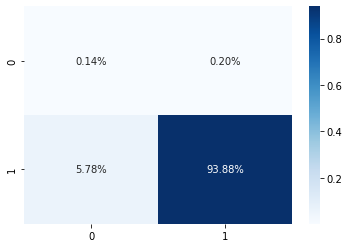

In [71]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

#Measurements
print('Precision: {}%'.format(round(precision_score(y_test, y_pred, average='binary')*100,2)))
print('Recall: {}%'.format(round(recall_score(y_test, y_pred, average='binary')*100,2)))
print('F1 score: {}%'.format(round(f1_score(y_test, y_pred, average='binary')*100,2)))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ROC_AUC score: 67.82%


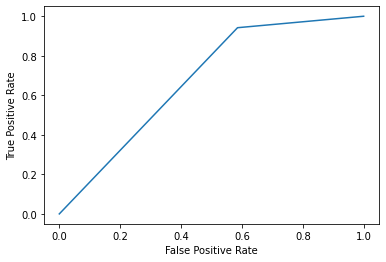

In [72]:
print('ROC_AUC score: '+str(round(roc_auc_score(y_test,y_pred)*100,2))+'%')
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.41      0.04       403
           1       1.00      0.94      0.97    118892

    accuracy                           0.94    119295
   macro avg       0.51      0.68      0.51    119295
weighted avg       0.99      0.94      0.97    119295



In [74]:
def SVC_autotune(X,y):
    # defining parameter range 
    param_test = {'kernel': ['rbf', 'sigmoid'],
                'C': [0.1, 1, 10, 100],  
                'gamma': [1, 0.1, 0.01, 0.001], 
                'gamma':['scale', 'auto'],} 

    gsearch = GridSearchCV(SVC(), param_grid = param_test, refit = True, verbose = 3, cv=5)
    
    register_spark() # register spark backendΩ
    with parallel_backend('spark',n_jobs=8):
        gsearch.fit(X,y)
    print('____________________________________________')
    print('tune SVC')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(gsearch.predict(X),y)

    return gsearch.best_estimator_

In [75]:
SVC_param = SVC_autotune(X_over,y_over)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend SparkDistributedBackend with 8 concurrent workers.
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] .. C=0.1, gamma=scale, kernel=sigmoid, score=0.504, total=   3.4s 1) / 1]
[CV] .. C=0.1, gamma=scale, kernel=sigmoid, score=0.486, total=   3.6s
[CV] .. C=0.1, gamma=scale, kernel=sigmoid, score=0.486, total=   3.6s          
[CV] ...... C=0.1, gamma=scale, kernel=rbf, score=0.541, total=   3.7s
[CV] ...... C=0.1, gamma=scale, kernel=rbf,

[CV] C=10, gamma=auto, kernel=sigmoid ................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.791, total=   3.7s
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.782, total=   3.5s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.797, total=   3.9s
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.781, total=   3.7s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] .... C=10, gamma=auto, kernel=sigmoid, score=0.475, total=   2.8s 1) / 1]
[CV] C=100, gamma=scale, kernel=rbf ..................................          
[CV] .... C=10, gamma=auto, kernel=sigmoid, score=0.486, total=   2.8s
[CV] C=100, gamma=scale, kernel=sigmoid ..............................          
[CV] .... C=10, gamma=auto, kernel=sigmoid, score

____________________________________________
tune SVC
____________________________________________
{'mean_fit_time': array([3.24984727, 2.96447358, 3.0627162 , 2.31542163, 2.93032913,
       1.81838536, 2.80208035, 2.02289863, 3.0021863 , 1.92944856,
       3.03623013, 2.25240674, 3.28030515, 1.54039326, 3.20253525,
       1.56050262]), 'std_fit_time': array([0.10108865, 0.08946118, 0.05753022, 0.06456386, 0.07076499,
       0.1528752 , 0.12767424, 0.07828495, 0.12443171, 0.10125618,
       0.11587848, 0.19669554, 0.04706956, 0.07318425, 0.12518281,
       0.25365447]), 'mean_score_time': array([0.62447829, 0.56191859, 0.64861722, 0.52177043, 0.67867441,
       0.37175946, 0.65509224, 0.46267033, 0.70856628, 0.41723437,
       0.62167029, 0.47320404, 0.51347446, 0.3462708 , 0.33848372,
       0.35284681]), 'std_score_time': array([0.02657814, 0.02072516, 0.01698841, 0.02472399, 0.02330795,
       0.03542834, 0.04703346, 0.01826515, 0.0315706 , 0.04286927,
       0.0382839 , 0.04991123,

In [76]:
y_pred = SVC_param.predict(X_test)

[[  189   214]
 [23274 95618]]
Precision: 99.78%
Recall: 80.42%
F1 score: 89.06%


<AxesSubplot:>

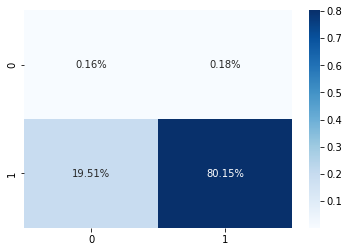

In [77]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

#Measurements
print('Precision: {}%'.format(round(precision_score(y_test, y_pred, average='binary')*100,2)))
print('Recall: {}%'.format(round(recall_score(y_test, y_pred, average='binary')*100,2)))
print('F1 score: {}%'.format(round(f1_score(y_test, y_pred, average='binary')*100,2)))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ROC_AUC score: 63.66%


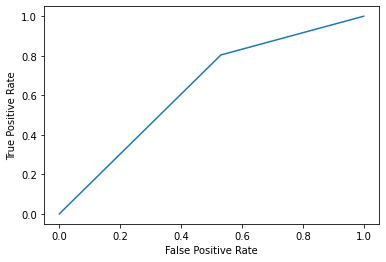

In [78]:
print('ROC_AUC score: '+str(round(roc_auc_score(y_test,y_pred)*100,2))+'%')
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.47      0.02       403
           1       1.00      0.80      0.89    118892

    accuracy                           0.80    119295
   macro avg       0.50      0.64      0.45    119295
weighted avg       0.99      0.80      0.89    119295



In [80]:
def xgb_autotune(X,y):
    param_test1 = {
     'max_depth':[5, 10 ,15, 20],
     'reg_alpha':[0.1,1,10],
     'learning_rate':[0.05, 0.01, 0.1],
    'n_estimators': [10,100,200,300]
    }

    gsearch = GridSearchCV(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),
                            param_grid = param_test1, scoring='roc_auc', n_jobs = 10, verbose=True, iid=False, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune max_depth, min_child_weight')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(gsearch.predict(X),y)
    return gsearch.best_estimator_

In [81]:
xgb_param = xgb_autotune(X_over,y_over)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 720 out of 720 | elapsed: 15.6min finished
/Users/chienyu/Codes/MachineLearning/MLEnv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


____________________________________________
tune max_depth, min_child_weight
____________________________________________
{'mean_fit_time': array([ 0.5221561 ,  0.49485741,  0.44393239,  3.98325262,  4.00905681,
        4.22223239,  8.02904596,  7.89183946,  8.38324056, 12.97888646,
       13.14140315, 10.42762356,  0.9097743 ,  0.92310276,  0.88250041,
        8.54837575,  8.76129956,  8.38094497, 16.19728336, 16.32764139,
       11.45899796, 24.97112164, 25.80752778, 12.85648475,  1.26975112,
        1.2478898 ,  1.23578959, 12.11877365, 12.01001344, 11.46484919,
       24.61920557, 24.39135871, 14.67395453, 34.64302101, 32.86267953,
       15.3761426 ,  1.50338287,  1.44175997,  1.44169741, 14.9155808 ,
       14.19609261, 12.7503458 , 29.34303036, 27.29546509, 15.62962861,
       41.38163266, 36.84968157, 16.37021365,  0.44855919,  0.4282526 ,
        0.44033928,  4.1593678 ,  4.50080638,  4.12000923,  7.96985307,
        7.94745083,  8.19990411, 12.07428379, 12.76903682, 13.18656

[[   183    220]
 [ 11633 107259]]
Precision: 99.8%
Recall: 90.22%
F1 score: 94.76%


<AxesSubplot:>

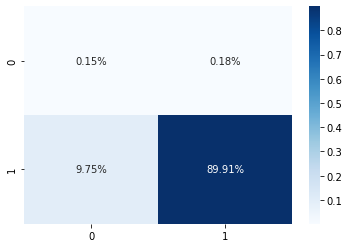

In [82]:
y_pred = xgb_param.predict(X_test)
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

#Measurements
print('Precision: {}%'.format(round(precision_score(y_test, y_pred, average='binary')*100,2)))
print('Recall: {}%'.format(round(recall_score(y_test, y_pred, average='binary')*100,2)))
print('F1 score: {}%'.format(round(f1_score(y_test, y_pred, average='binary')*100,2)))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ROC_AUC score: 67.81%


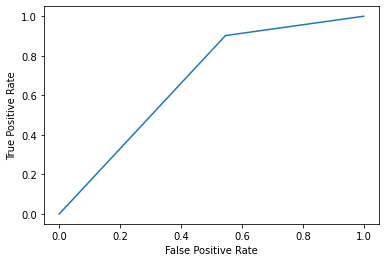

In [83]:
print('ROC_AUC score: '+str(round(roc_auc_score(y_test,y_pred)*100,2))+'%')
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.45      0.03       403
           1       1.00      0.90      0.95    118892

    accuracy                           0.90    119295
   macro avg       0.51      0.68      0.49    119295
weighted avg       0.99      0.90      0.94    119295

